In [28]:
import pandas as pd


# مقدار حد آستانه را وارد کنید یا اصلاح کنید

In [29]:
threshold=0.95

In [30]:
df=pd.read_excel('data_u6.xlsx')
df.head()

,obj,class,f1,f2,f3,f5,f6,f7,f8,f9,...,f2541,f2545,f2546,f2549,f2550,f2551,f2553,f2555,f2556,f2557
0,1,1,0.778021,0.370202,40.129490,105.621967,75.000000,119.854078,120.623381,3406.541667,...,2709.139464,0.000382,7.584146,0.021298,0.002399,294890.01230,44.432247,36,1.0,3.0
1,2,1,0.821474,0.245085,22.974936,92.439169,72.090221,73.348483,99.206855,2486.166667,...,1797.152900,0.000725,7.572633,0.014414,0.003574,196790.75310,47.867235,28,1.0,5.0
2,3,1,0.223832,0.178680,24.034978,71.400280,42.296572,78.447435,94.323910,1298.166667,...,824.070347,0.001518,7.419445,0.012748,0.007548,93491.09881,58.766584,27,1.0,6.0
3,4,1,0.825111,0.059789,7.531322,64.761099,55.362442,6.082763,90.255194,70.250000,...,45.985507,0.015250,5.756863,0.015342,0.030374,28001.93655,106.215785,29,0.0,3.0
4,5,1,0.311822,0.134679,13.241971,50.447993,8.246211,17.464249,87.960218,479.125000,...,388.739696,0.002676,7.166653,0.010228,0.011863,165579.87010,116.725737,31,1.0,3.0


In [31]:
def read_excel_to_dict(file_path):
    data = pd.read_excel(file_path)  # Assuming the first column is the index
    data_dict = data.iloc[0].to_dict()
    return data_dict

file_path = "not_sort2.xlsx"  # Replace with the actual file path
data_dict = read_excel_to_dict(file_path)



In [32]:
#import random
def reduce_correlated_columns3(df, correlated_groups, p_values):
    reduced_columns = []
    selected_columns=[]
    p_val_columns=[]
    corr_columns=[]
    rand_columns=[]
    dff=df
    all_columns=[]
    for group in correlated_groups:
        candidates=[]
        fcandidates=[]
        min_pvalue_column,min_p_value = find_min_pvalue_column(group, p_values)

        for col in group:
          all_columns.append(col)
          if p_values[col]==min_p_value:
            candidates.append(col)
        if len(candidates)==1:
          selected_columns.append(candidates[0])
          p_val_columns.append(candidates[0])

        if len(candidates)>1:
            #select on
            #random_index = random.randint(0, len(candidates) - 1)
            #random_candidate = candidates[random_index]
            #selected_columns.append(random_candidate)
            random_candidate=candidates[0]
            selected_columns.append(random_candidate)
            #print(candidates)
            #print("Randomly selected candidate:", random_candidate)
            rand_columns.append(random_candidate)
    print(len(set(selected_columns)),'out of ',len(set(all_columns)), ' columns have been selected')
    return set(selected_columns) , set(corr_columns),set(p_val_columns)
def detect_correlation_groups(df, threshold):
    corr_matrix = df.corr(method='spearman').abs()
    column_correlation_groups = {}  # To store the correlated groups for each column

    for column in corr_matrix.columns:
        correlated_group = set()

        if column not in column_correlation_groups:
            correlated_group.add(column)

            for other_column in corr_matrix.columns:
                if other_column != column:
                    if other_column in column_correlation_groups and column in column_correlation_groups[other_column]:
                        correlated_group.update(column_correlation_groups[other_column])

                    elif corr_matrix.loc[column, other_column] > threshold:
                        correlated_group.add(other_column)

            if len(correlated_group) > 1:
                #print(correlated_group)
                for col in correlated_group:
                    column_correlation_groups[col] = correlated_group

    return list(column_correlation_groups.values())
def find_min_pvalue_column(correlation_group, p_values):
    min_pvalue = np.inf
    min_pvalue_column = None
    for col in correlation_group:
        if p_values[col] < min_pvalue:
            min_pvalue = p_values[col]
            min_pvalue_column = col
    return min_pvalue_column,min_pvalue

In [33]:
from natsort import natsorted
import numpy as np
import pandas as pd

final_df=df
i=0
p_values_dict=data_dict
final_df_without_first_and_second_column=final_df.drop(columns=['class','obj'])
correlation_matrix = final_df_without_first_and_second_column.corr(method='spearman')
correlation_array = correlation_matrix.to_numpy()
upper_triangular_matrix = np.triu(correlation_array, k=1)
upper_triangular_df = pd.DataFrame(upper_triangular_matrix, columns=correlation_matrix.columns, index=correlation_matrix.index)
absolute_upper_triangular_df = np.abs(upper_triangular_df)
absolute_upper_triangular_df = absolute_upper_triangular_df.applymap(lambda x: float(x))
absolute_upper_triangular_df = absolute_upper_triangular_df.applymap(lambda x: np.nan if x < threshold else 1)
N=absolute_upper_triangular_df.count().sum()
while N!=0:
  print('-------')

  print(N,' correlated feature exist')

  correlated_groups = detect_correlation_groups(final_df_without_first_and_second_column, threshold)
  columns,corr_columns,p_val_columns=reduce_correlated_columns3(final_df.copy(), correlated_groups, p_values_dict)
  column2remove=[]
  for group in correlated_groups:
    for col in group:
      column2remove.append(col)
  keptcolumns=[]
  for col in final_df.columns:
    if col not in set(column2remove):
      keptcolumns.append(col)
  removed_columns=[]
  for col in set(column2remove):
    if col not in columns:
      removed_columns.append(col)
  final_columns=list(keptcolumns)+list(columns)
  sorted_list = sorted(final_columns)
  sorted_list = natsorted(sorted_list)
  item_to_move = 'obj'
  index_to_move = sorted_list.index(item_to_move)
  sorted_list.pop(index_to_move)
  sorted_list.insert(0, item_to_move)
  final_df = final_df[sorted_list]
  final_df_without_first_and_second_column=final_df.drop(columns=['class','obj'])
  correlation_matrix = final_df_without_first_and_second_column.corr(method='spearman')
  correlation_array = correlation_matrix.to_numpy()
  upper_triangular_matrix = np.triu(correlation_array, k=1)
  upper_triangular_df = pd.DataFrame(upper_triangular_matrix, columns=correlation_matrix.columns, index=correlation_matrix.index)
  absolute_upper_triangular_df = np.abs(upper_triangular_df)
  absolute_upper_triangular_df = absolute_upper_triangular_df.applymap(lambda x: float(x))
  absolute_upper_triangular_df = absolute_upper_triangular_df.applymap(lambda x: np.nan if x < threshold else 1)
  old_N=N
  N=absolute_upper_triangular_df.count().sum()
  print('itteration number ',i)
  print('Number of correlated features reduced from ',old_N, ' to ',N)
  if i==0:
    selected=keptcolumns
  i=i+1
  #p_values_dict=
print('********************************')
print('total itterations: ',i)
print(N,' correlated feature exist')

final_df.head()

-------
28542  correlated feature exist
239 out of  1144  columns have been selected
itteration number  0
Number of correlated features reduced from  28542  to  83
-------
83  correlated feature exist
30 out of  68  columns have been selected
itteration number  1
Number of correlated features reduced from  83  to  4
-------
4  correlated feature exist
3 out of  6  columns have been selected
itteration number  2
Number of correlated features reduced from  4  to  1
-------
1  correlated feature exist
1 out of  2  columns have been selected
itteration number  3
Number of correlated features reduced from  1  to  0
********************************
total itterations:  4
0  correlated feature exist


,obj,class,f1,f2,f3,f5,f6,f7,f8,f15,...,f2456,f2458,f2470,f2498,f2501,f2549,f2551,f2555,f2556,f2557
0,1,1,0.778021,0.370202,40.129490,105.621967,75.000000,119.854078,120.623381,181.980039,...,3.557054,105.219160,851.641235,0.904455,7.808422,0.021298,294890.01230,36,1.0,3.0
1,2,1,0.821474,0.245085,22.974936,92.439169,72.090221,73.348483,99.206855,170.479532,...,2.383064,82.325016,854.755646,0.936213,7.733367,0.014414,196790.75310,28,1.0,5.0
2,3,1,0.223832,0.178680,24.034978,71.400280,42.296572,78.447435,94.323910,162.379030,...,3.917032,38.326794,757.625519,0.845237,7.550692,0.012748,93491.09881,27,1.0,6.0
3,4,1,0.825111,0.059789,7.531322,64.761099,55.362442,6.082763,90.255194,188.893924,...,0.244422,23.737023,788.456360,1.000000,4.620787,0.015342,28001.93655,29,0.0,3.0
4,5,1,0.311822,0.134679,13.241971,50.447993,8.246211,17.464249,87.960218,194.212082,...,0.780103,101.729220,920.536011,0.954157,7.265203,0.010228,165579.87010,31,1.0,3.0


#  ذخیره و نمایش و............

In [34]:
print(f'final_data_{int(threshold*100)}.csv')

final_data_95.csv


In [35]:
final_df.head()

,obj,class,f1,f2,f3,f5,f6,f7,f8,f15,...,f2456,f2458,f2470,f2498,f2501,f2549,f2551,f2555,f2556,f2557
0,1,1,0.778021,0.370202,40.129490,105.621967,75.000000,119.854078,120.623381,181.980039,...,3.557054,105.219160,851.641235,0.904455,7.808422,0.021298,294890.01230,36,1.0,3.0
1,2,1,0.821474,0.245085,22.974936,92.439169,72.090221,73.348483,99.206855,170.479532,...,2.383064,82.325016,854.755646,0.936213,7.733367,0.014414,196790.75310,28,1.0,5.0
2,3,1,0.223832,0.178680,24.034978,71.400280,42.296572,78.447435,94.323910,162.379030,...,3.917032,38.326794,757.625519,0.845237,7.550692,0.012748,93491.09881,27,1.0,6.0
3,4,1,0.825111,0.059789,7.531322,64.761099,55.362442,6.082763,90.255194,188.893924,...,0.244422,23.737023,788.456360,1.000000,4.620787,0.015342,28001.93655,29,0.0,3.0
4,5,1,0.311822,0.134679,13.241971,50.447993,8.246211,17.464249,87.960218,194.212082,...,0.780103,101.729220,920.536011,0.954157,7.265203,0.010228,165579.87010,31,1.0,3.0


In [36]:
final_df.to_csv(f'final_data_{int(threshold*100)}.csv')
kept_df=final_df[list(selected)]
corr_df = final_df.drop(columns=list(selected))
corr_df.to_csv(f'selected_columns_{int(threshold*100)}.csv')
kept_df.to_csv(f'no_corr_columns_{int(threshold*100)}.csv')

In [37]:
len(kept_df.columns)

192

In [38]:
len(corr_df.columns)

197

In [ ]:
import pandas as pd
df_without_first_and_second_column=df.drop(columns=['class','obj'])
# Assuming correlation_matrix is your calculated correlation matrix
correlation_matrix = df_without_first_and_second_column.corr(method='spearman')

# Get the names of the features
feature_names = correlation_matrix.columns.tolist()

# Reshape the correlation matrix into a vector
correlation_vector = correlation_matrix.values.flatten()

# Create a DataFrame with feature names and correlation values
correlation_df = pd.DataFrame({
    'Feature 1': [feature_names[i] for i in range(len(feature_names)) for _ in range(len(feature_names))],
    'Feature 2': feature_names * len(feature_names),
    'Correlation': correlation_vector
})
correlation_df = correlation_df[correlation_df['Feature 1'] < correlation_df['Feature 2']]
correlation_df

,Feature 1,Feature 2,Correlation
1,f1,f2,0.680684
2,f1,f3,0.493837
3,f1,f5,0.403387
4,f1,f6,0.666085
5,f1,f7,0.467972
...,...,...,...
1778799,f2557,f994,-0.293577
1778800,f2557,f995,0.360733
1778801,f2557,f996,-0.382315
1778802,f2557,f997,-0.300684


In [ ]:
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)
correlation_df

,Feature 1,Feature 2,Correlation
12515,f11,f862,0.999988
11180,f10,f861,0.999988
1399087,f2044,f2055,0.999976
958537,f1286,f1297,0.999976
1177484,f1627,f1657,0.999976
...,...,...,...
928475,f1234,f14,-0.999520
15896,f14,f2364,-0.999532
14900,f14,f383,-0.999556
15054,f14,f662,-0.999568


In [ ]:
correlation_df.to_csv('correlation_df_vec.csv')

In [ ]:
abs_correlation_df = correlation_df.sort_values(by='Correlation', key=abs, ascending=False)
abs_correlation_df

,Feature 1,Feature 2,Correlation
12515,f11,f862,0.999988
11180,f10,f861,0.999988
1399087,f2044,f2055,0.999976
958537,f1286,f1297,0.999976
1177484,f1627,f1657,0.999976
...,...,...,...
101138,f116,f2124,0.000012
843277,f1100,f318,0.000012
1077884,f1479,f15,0.000012
1355149,f1966,f2209,0.000000


In [ ]:
abs_correlation_df.to_csv('abs_correlation_df_vec.csv')

In [ ]:
correlation_matrix_final_df = final_df.corr(method='spearman')
correlation_matrix_final_df.head()

,obj,class,f1,f2,f3,f5,f7,f15,f24,f43,...,f2419,f2423,f2452,f2453,f2458,f2470,f2551,f2555,f2556,f2557
obj,1.000000,0.859810,0.203324,0.396136,0.407069,0.264064,0.304430,-0.195044,-0.367393,0.223306,...,-0.210105,-0.289013,-0.317144,0.300954,0.297978,-0.241428,0.153567,0.478189,0.746159,0.641906
class,0.859810,1.000000,0.279857,0.445259,0.438978,0.270088,0.375820,-0.271482,-0.386636,0.254733,...,-0.279857,-0.332199,-0.371980,0.400593,0.366396,-0.247754,0.217744,0.531862,0.801361,0.747655
f1,0.203324,0.279857,1.000000,0.680684,0.493837,0.403387,0.467972,-0.015938,0.005365,0.176586,...,-0.156364,-0.458326,-0.415278,0.240024,0.271059,-0.032775,0.372697,0.043332,0.245684,0.259888
f2,0.396136,0.445259,0.680684,1.000000,0.858146,0.529928,0.583088,-0.099082,-0.100618,0.203540,...,-0.272811,-0.511359,-0.539382,0.499754,0.446289,-0.015158,0.536838,0.176647,0.405439,0.465892
f3,0.407069,0.438978,0.493837,0.858146,1.000000,0.688255,0.764763,-0.102886,-0.113987,0.288041,...,-0.236544,-0.590255,-0.600876,0.609085,0.513855,-0.019682,0.591551,0.241360,0.392221,0.499648


In [ ]:
correlation_matrix_final_df.to_csv(f'correlation_matrix_final_df_{int(threshold*100)}.csv')

In [ ]:
# Get the names of the features
feature_names = correlation_matrix_final_df.columns.tolist()

# Reshape the correlation matrix into a vector
correlation_vector = correlation_matrix_final_df.values.flatten()

# Create a DataFrame with feature names and correlation values
correlation_df = pd.DataFrame({
    'Feature 1': [feature_names[i] for i in range(len(feature_names)) for _ in range(len(feature_names))],
    'Feature 2': feature_names * len(feature_names),
    'Correlation': correlation_vector
})
correlation_df = correlation_df[correlation_df['Feature 1'] < correlation_df['Feature 2']]
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)
correlation_df.to_csv(f'correlation_df_vec_{int(threshold*100)}.csv')
correlation_df

,Feature 1,Feature 2,Correlation
3272,f196,f744,0.896514
14405,f1058,f1142,0.896442
14753,f1088,f995,0.889913
8462,f693,f739,0.889613
4863,f387,f403,0.885905
...,...,...,...
27001,f2150,f2160,-0.883720
25741,f2071,f2080,-0.888197
19264,f1546,f1572,-0.890513
19441,f1548,f1554,-0.892505


In [ ]:
abs_correlation_df = correlation_df.sort_values(by='Correlation', key=abs, ascending=False)
abs_correlation_df.to_csv(f'abs_correlation_df_vec_{int(threshold*100)}.csv')
abs_correlation_df

,Feature 1,Feature 2,Correlation
3272,f196,f744,0.896514
14405,f1058,f1142,0.896442
23043,f1844,f1861,-0.894857
19441,f1548,f1554,-0.892505
19264,f1546,f1572,-0.890513
...,...,...,...
2630,f116,f1816,0.000228
2637,f116,f1861,0.000204
27754,f2190,f43,0.000180
20530,f1611,f1816,0.000144


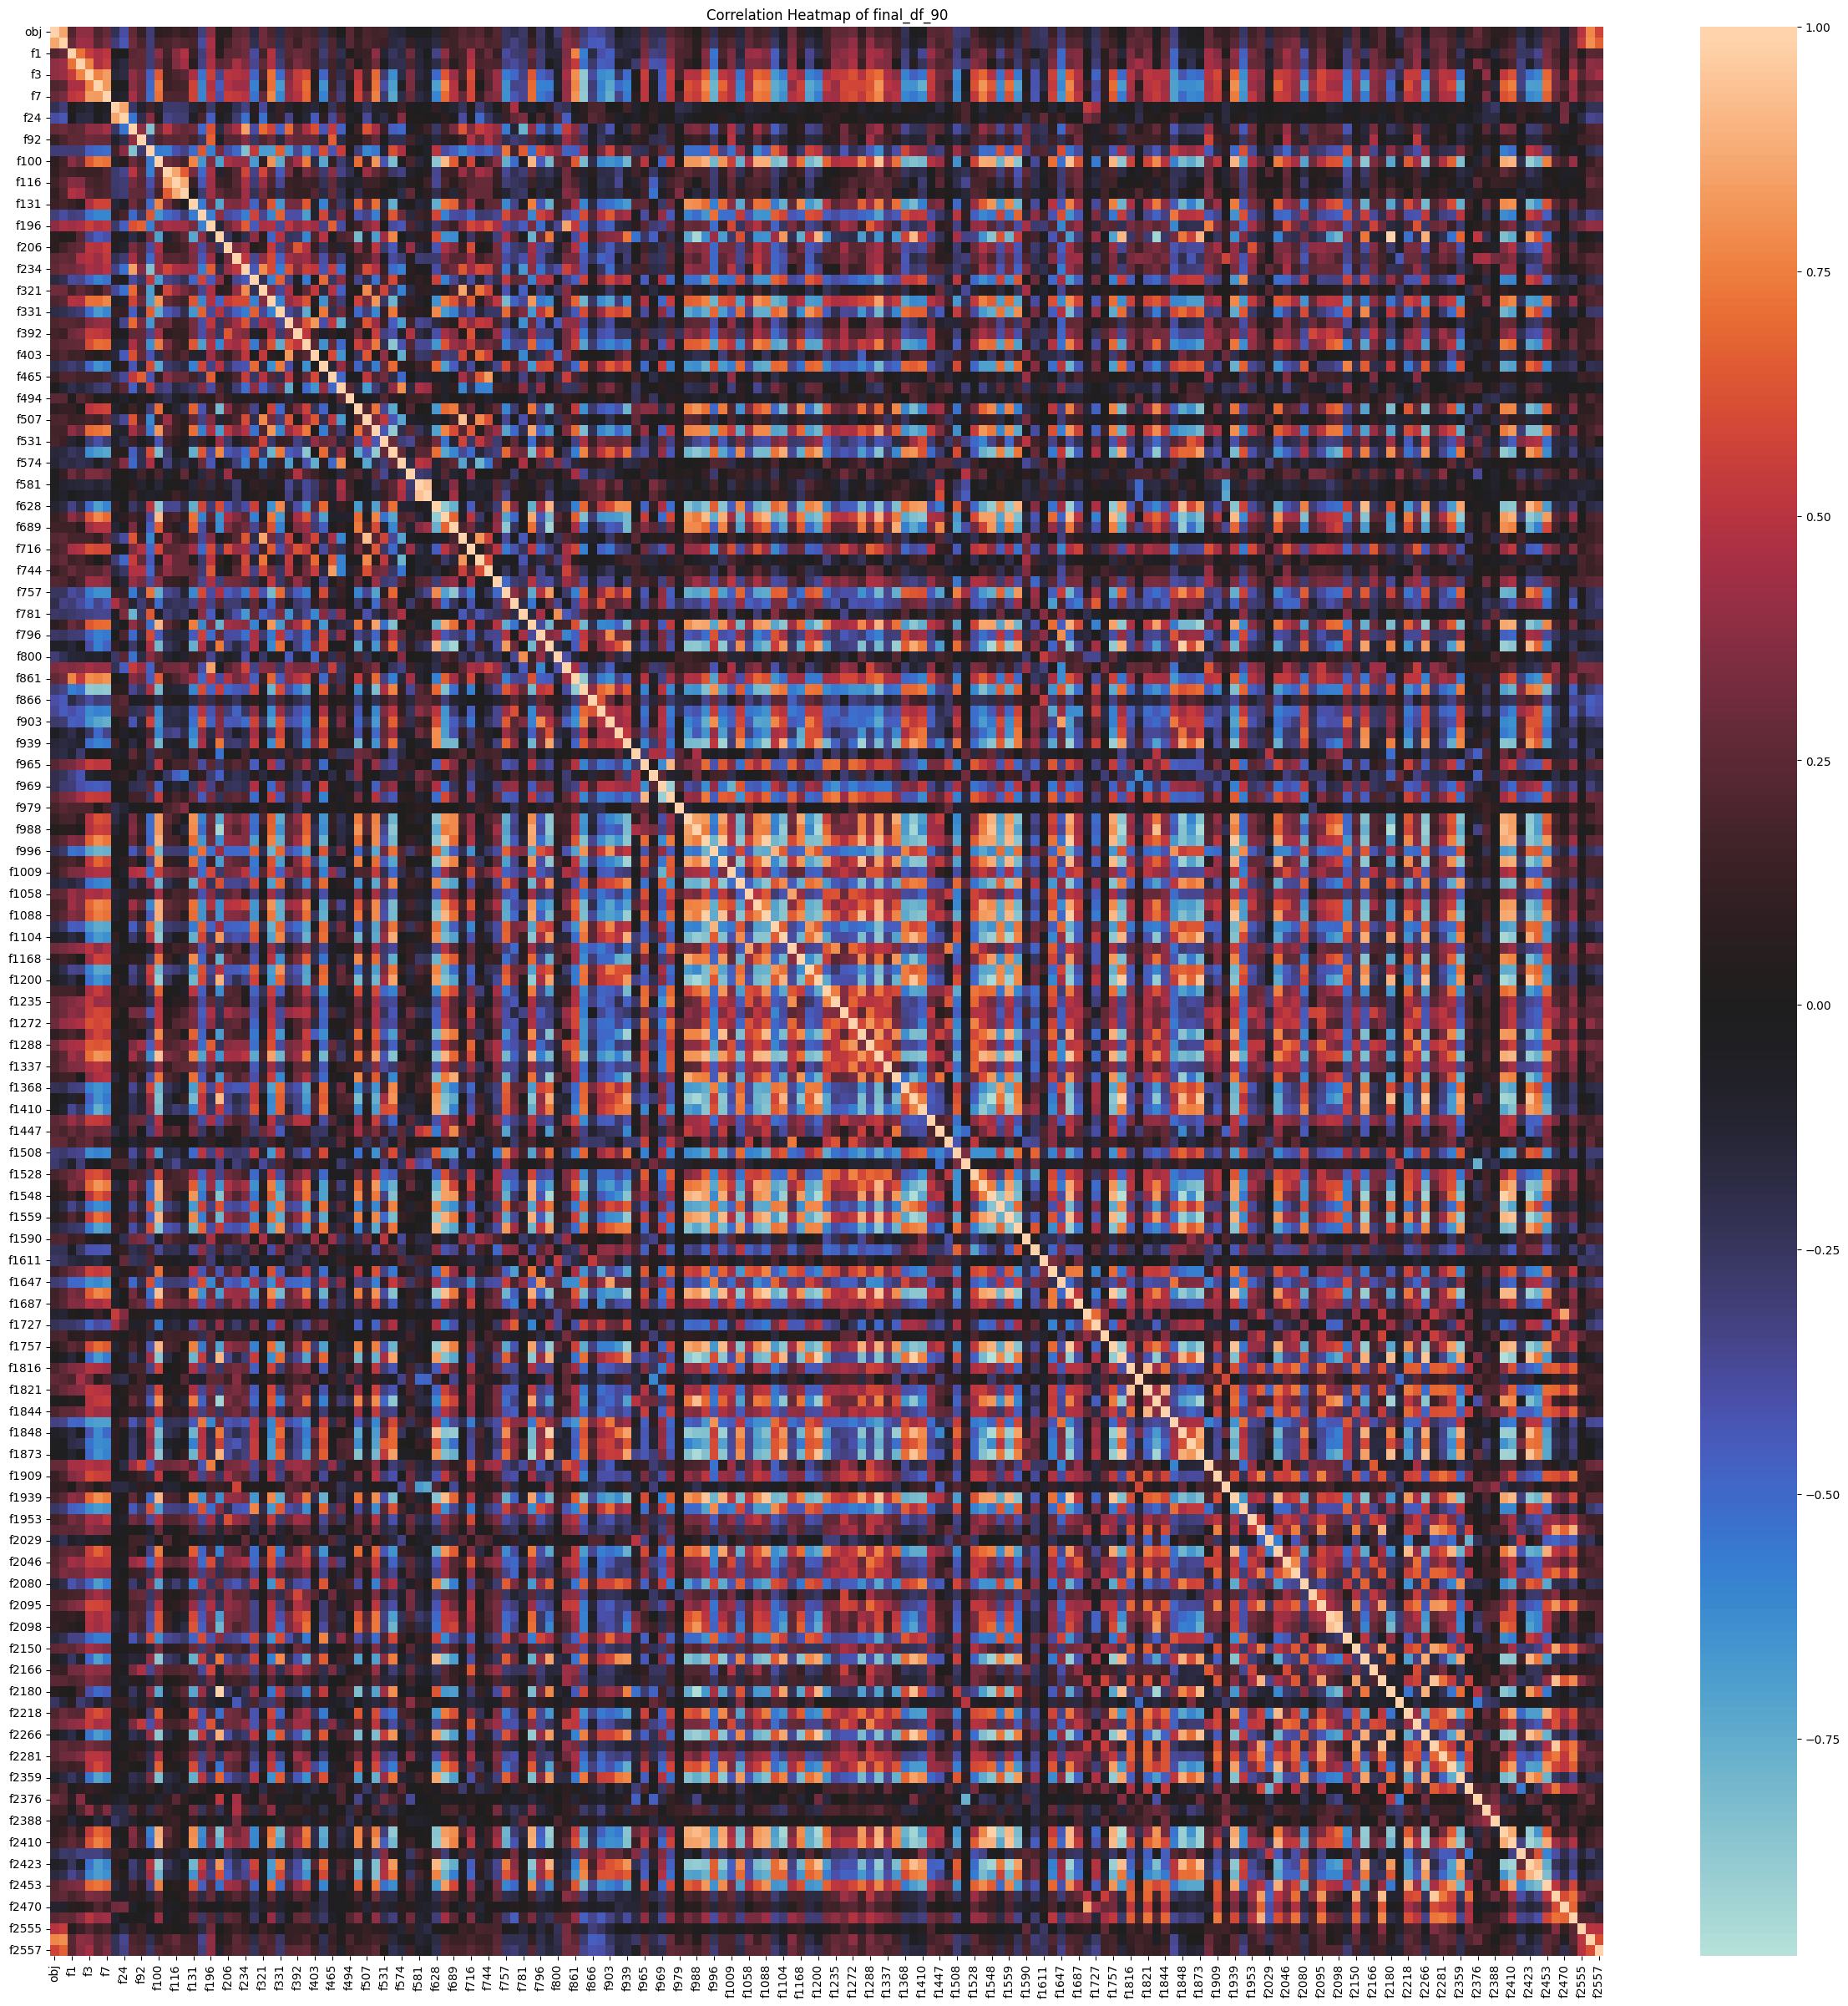

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = final_df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(30, 30))

sns.heatmap(correlation_matrix, center=0)

plt.title(f'Correlation Heatmap of final_df_{int(threshold*100)}')

plt.show()


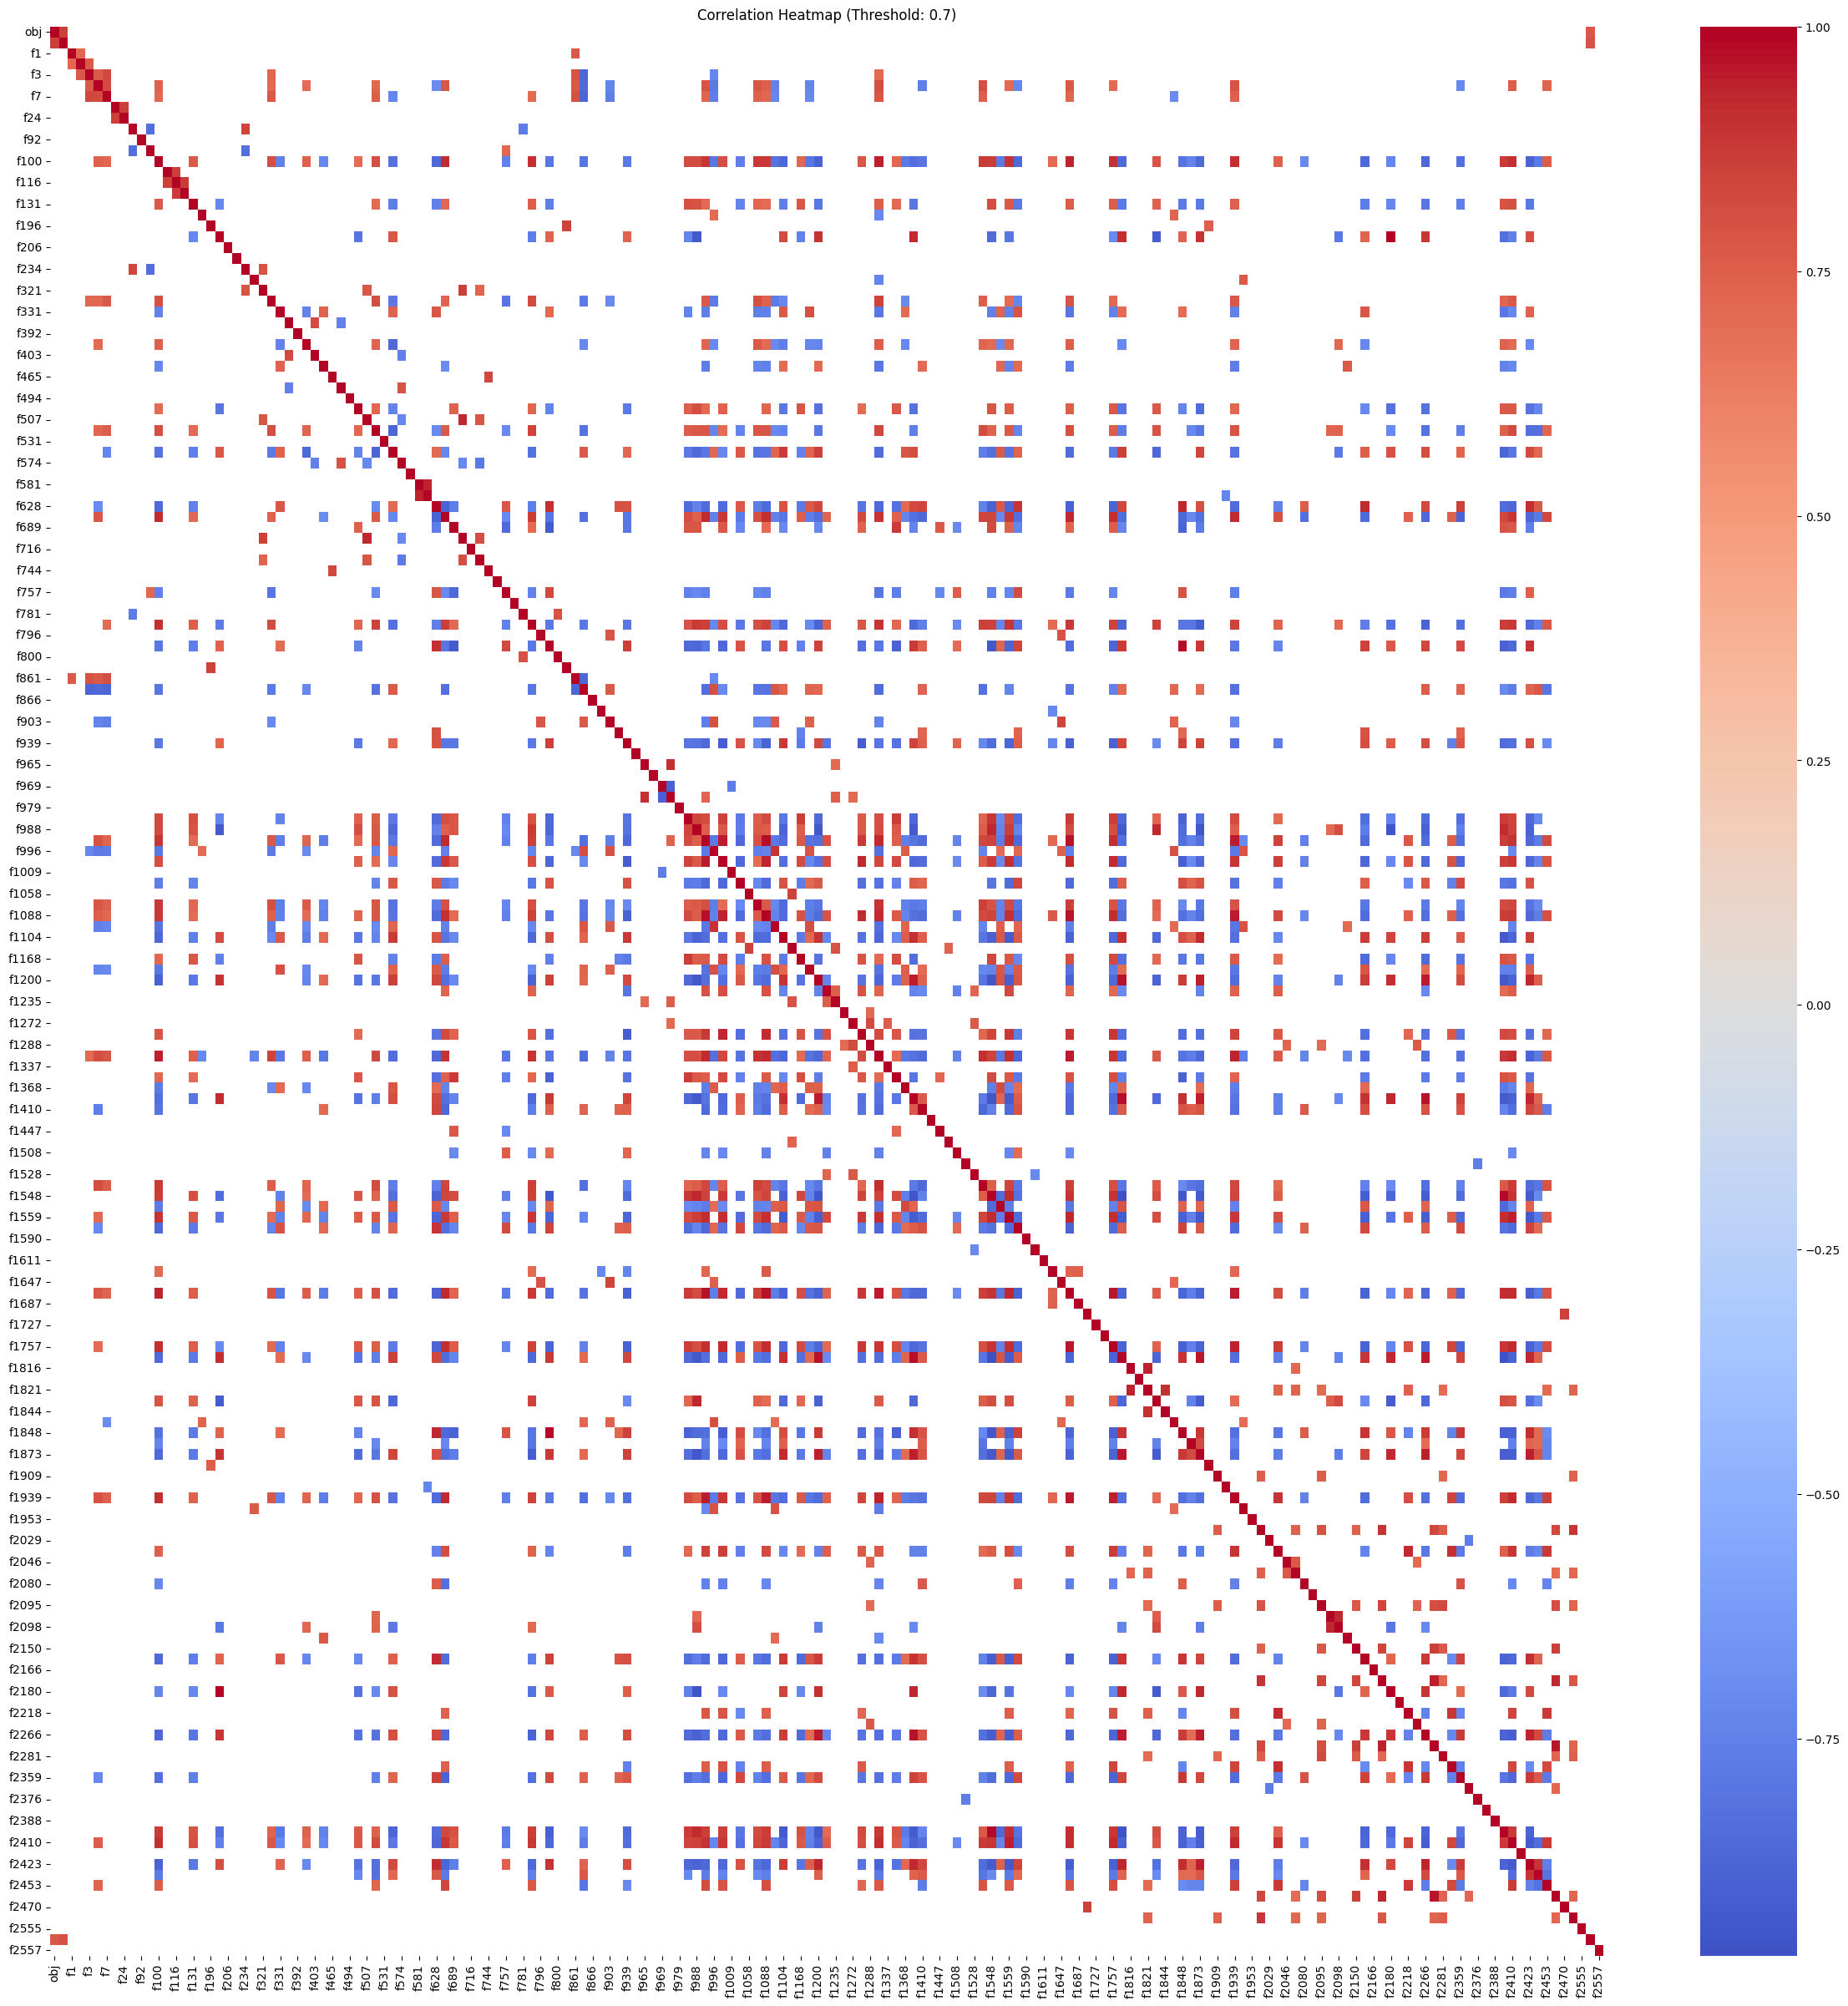

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_df is your dataframe
# If your dataframe contains non-numeric columns, you might want to select only numeric columns for correlation
numeric_columns = final_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Set a correlation threshold
correlation_threshold = 0.7
correlation_matrix_filtered = correlation_matrix[correlation_matrix.abs() > correlation_threshold]

# Set up the matplotlib figure with a larger size
plt.figure(figsize=(30, 30))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix_filtered, cmap='coolwarm', center=0)

# Add a title
plt.title(f'Correlation Heatmap (Threshold: {correlation_threshold})')

# Show the plot
plt.show()


<Figure size 30000x30000 with 0 Axes>

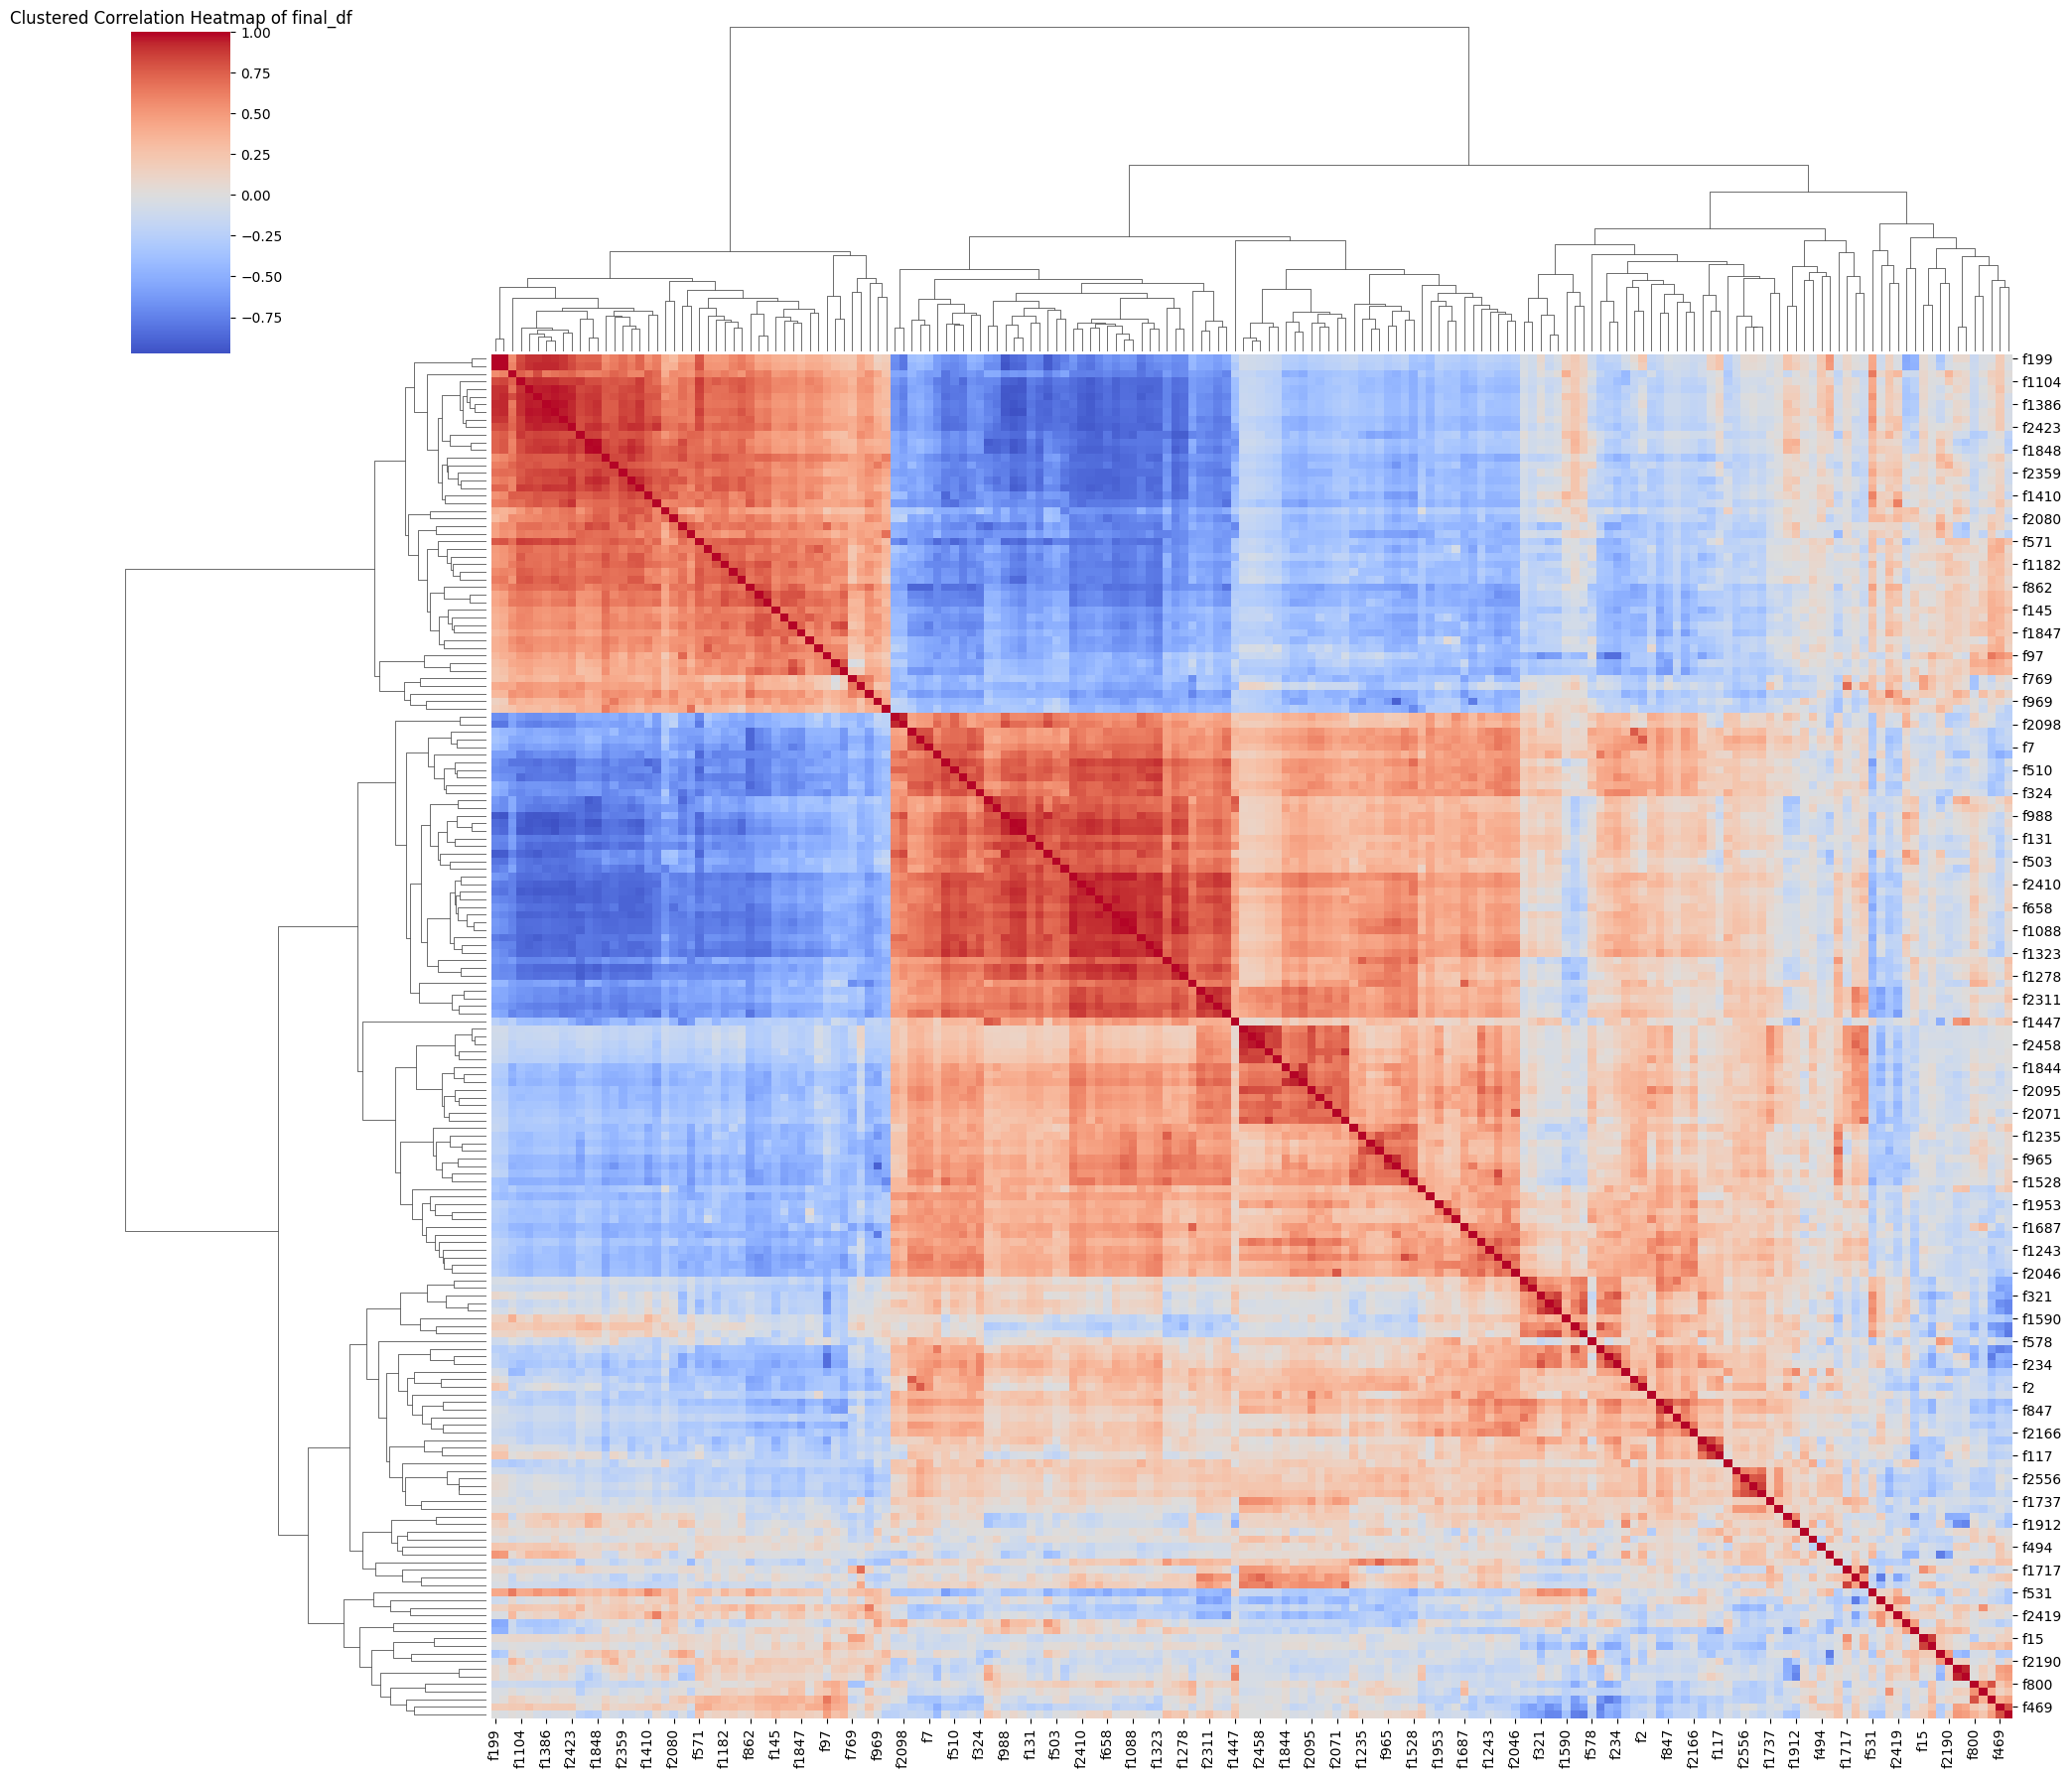

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

# Assuming final_df is your dataframe
# If your dataframe contains non-numeric columns, you might want to select only numeric columns for correlation
numeric_columns = final_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Calculate linkage matrix for hierarchical clustering
linkage = hierarchy.linkage(correlation_matrix, method='average')

# Set up the matplotlib figure with a larger size
plt.figure(figsize=(300, 300))

# Create a clustered heatmap using seaborn
sns.clustermap(correlation_matrix, method='average', cmap='coolwarm', center=0, figsize=(20, 18), row_linkage=linkage, col_linkage=linkage)

# Add a title
plt.title('Clustered Correlation Heatmap of final_df')

# Show the plot
plt.show()


#  Clustered Heatmap
 یک نوع نمودار است که با استفاده از رنگ‌ها و خوشه‌بندی، ارتباطات میان متغیرها را نمایش می‌دهد. در این نمودار، داده‌های ماتریسی از همبستگی (مانند ماتریس کورلیشن) یا سایر اطلاعات مشابه، با استفاده از رنگ‌ها نمایش داده می‌شوند و سعی می‌شود تا مشاهده‌هایی دربارهٔ الگوهای همبستگی و تفاوت‌ها در داده‌ها ارائه شود.



#  Clustered Heatmap
 به این دلیل که از همبستگی‌ها برای خوشه‌بندی و ترتیب داده‌ها استفاده می‌کند، به نام "خوشه‌بندی شده" می‌آید. ایده اصلی این نمودار این است که متغیرهایی که همبستگی بالاتری با یکدیگر دارند، در یک خوشه قرار گیرند. این امر به شما کمک می‌کند الگوها و ساختارهایی که در داده‌ها وجود دارند را تشخیص دهید.



# با داشتن تعداد زیادی متغیر، نمودار  هیت مپ کلاستر شده می‌تواند به شما کمک کند تا درک بهتری از روابط میان متغیرها پیدا کنید، اما با توجه به تعداد زیادی متغیر، خوانایی نمودار ممکن است کاهش یابد و نیاز به تحلیل دقیق‌تر داشته باشید.




